In [3]:
import pandas as pd

# === 1. Load Dataset ===
file_path = "TSLA_2015_2025_Histogram.csv"
df = pd.read_csv(file_path)

# === 2. Membersihkan nilai numerik ===
# Hilangkan koma dan ubah menjadi float
cols_to_clean = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_clean:
    df[col] = df[col].str.replace(',', '').astype(float)

# === 3. Konversi kolom tanggal dan urutkan ===
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

# === 4. Buat kolom target klasifikasi: 'Price_Up' ===
# Price_Up = 1 jika harga penutupan naik dari hari sebelumnya
df['Price_Up'] = df['Close'].diff().apply(lambda x: 1 if x > 0 else 0)

# === 5. Hapus baris pertama (karena NaN akibat diff()) ===
df = df.dropna().reset_index(drop=True)

# === 6. Simpan dataset hasil preprocessing jika diperlukan ===
df.to_csv("TSLA_Preprocessed.csv", index=False)

# Tampilkan 5 baris hasil akhir
print(df[['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Up']].head())


        date          Open          High           Low         Close  \
0 2015-01-02  1.485800e+08  1.488333e+09  1.421733e+09  1.462067e+09   
1 2015-01-05  1.430333e+09  1.443333e+08  1.381067e+09  1.400600e+09   
2 2015-01-06  1.400400e+09  1.428000e+09  1.361400e+09  1.408533e+09   
3 2015-01-07  1.422333e+09  1.431867e+09  1.398533e+09  1.406333e+09   
4 2015-01-08  1.418733e+09  1.425333e+09  1.400067e+09  1.404133e+08   

       Volume  Price_Up  
0  71466000.0         0  
1  80527500.0         0  
2  93928500.0         1  
3  44526000.0         0  
4  51637500.0         0  


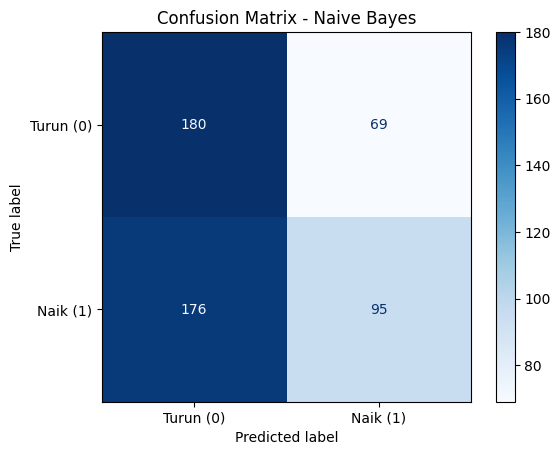

=== Classification Report ===
              precision    recall  f1-score     support
Turun (0)      0.505618  0.722892  0.595041  249.000000
Naik (1)       0.579268  0.350554  0.436782  271.000000
accuracy       0.528846  0.528846  0.528846    0.528846
macro avg      0.542443  0.536723  0.515911  520.000000
weighted avg   0.544001  0.528846  0.512564  520.000000

=== Analisis Kesalahan ===
True Negatives (TN): 180
False Positives (FP): 69
False Negatives (FN): 176
True Positives (TP): 95
Akurasi     : 0.53
Precision   : 0.58 (Kemampuan memprediksi 'Naik' dengan benar)
Recall      : 0.35 (Kemampuan menangkap semua 'Naik')
F1-Score    : 0.44 (Harmonis precision dan recall)


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Load Dataset Preprocessed ===
df = pd.read_csv("TSLA_Preprocessed.csv")

# === 2. Pisahkan fitur dan target ===
X = df[['Open', 'High', 'Low', 'Close', 'Volume']]
y = df['Price_Up']

# === 3. Split Data: 80% Training, 20% Testing ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 4. Train model Naive Bayes ===
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# === 5. Confusion matrix ===
cm = confusion_matrix(y_test, y_pred)
labels = ['Turun (0)', 'Naik (1)']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# === 6. Classification report ===
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("=== Classification Report ===")
print(report_df)

# === 7. Analisa kesalahan ===
TN, FP, FN, TP = cm.ravel()

print("\n=== Analisis Kesalahan ===")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")
print(f"Akurasi     : {(TP + TN) / (TP + TN + FP + FN):.2f}")
print(f"Precision   : {TP / (TP + FP):.2f} (Kemampuan memprediksi 'Naik' dengan benar)")
print(f"Recall      : {TP / (TP + FN):.2f} (Kemampuan menangkap semua 'Naik')")
print(f"F1-Score    : {2 * TP / (2 * TP + FP + FN):.2f} (Harmonis precision dan recall)")

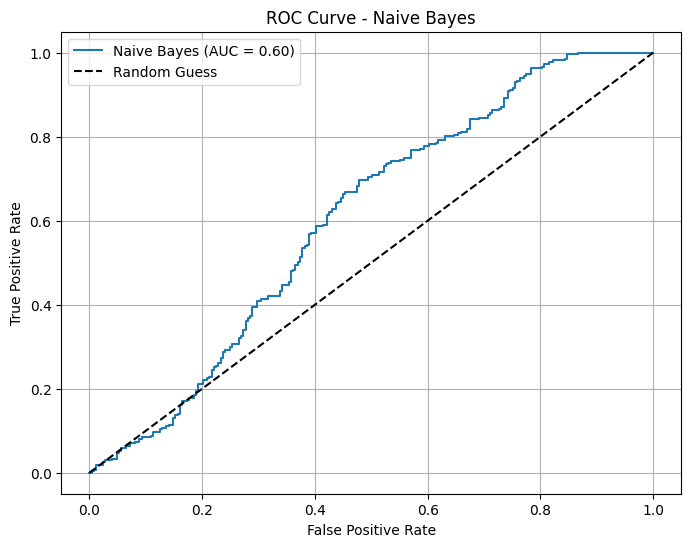

AUC Score: 0.6049


In [5]:
from sklearn.metrics import roc_curve, roc_auc_score

# === Prediksi probabilitas (untuk ROC) ===
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilitas kelas 1 (Naik)

# === Hitung ROC Curve dan AUC ===
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# === Plot ROC Curve ===
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()

# === Print AUC Score ===
print(f"AUC Score: {auc_score:.4f}")